In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv('./Construction_mod.csv')

# Replace null values with 0
df.fillna(0, inplace=True)

# Print the data
print(df)

            Date Symbol Series  Prev Close     Open     High      Low  \
0     2015-01-01     LT     EQ     1494.65  1493.80  1506.90  1492.00   
1     2015-01-02     LT     EQ     1502.95  1501.50  1539.00  1501.50   
2     2015-01-05     LT     EQ     1534.65  1545.35  1571.00  1545.35   
3     2015-01-06     LT     EQ     1556.00  1541.00  1544.75  1496.05   
4     2015-01-07     LT     EQ     1504.10  1498.75  1510.00  1485.55   
...          ...    ...    ...         ...      ...      ...      ...   
1561  2021-04-26     LT     EQ     1322.90  1330.05  1341.20  1323.00   
1562  2021-04-27     LT     EQ     1335.90  1339.00  1388.45  1335.90   
1563  2021-04-28     LT     EQ     1380.65  1384.85  1399.95  1372.50   
1564  2021-04-29     LT     EQ     1375.90  1383.95  1389.55  1353.50   
1565  2021-04-30     LT     EQ     1358.65  1350.00  1365.00  1336.10   

         Last    Close     VWAP   Volume      Turnover  Trades  \
0     1503.95  1502.95  1500.79   449532  6.746545e+13   

In [3]:

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

In [4]:
# Function for calculating the metrics of a model trained on a particular stock in the sector.
def stockMetrics(y_test, predictions):
    # Calculate metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    nrmse = rmse / (np.max(y_test) - np.min(y_test))
    actual_growth = ((y_test[-1][0] - y_test[0][0]) / y_test[0][0]) * 100
    predicted_growth = ((predictions[-1][0] - predictions[0][0]) / predictions[0][0]) * 100
    
    return mse, rmse, mae, nrmse, actual_growth, predicted_growth

In [5]:
# Function for plotting the Actual vs Predicted Growth of each stock in a sector.
def stockActVsPred(stock_df, y_test, predictions):
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(stock_df['Date'][len(stock_df)-len(predictions):], y_test, label='Actual')
    plt.plot(stock_df['Date'][len(stock_df)-len(predictions):], predictions, label='Predicted')
    plt.title(f'Actual vs Predicted Stock Closing Prices for {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Stock Closing Price')
    plt.legend()
    plt.show()

Epoch 1/10
26/26 [==============================] - 7s 85ms/step - loss: 0.0452 - val_loss: 0.0065
Epoch 2/10
26/26 [==============================] - 1s 36ms/step - loss: 0.0144 - val_loss: 0.0080
Epoch 3/10
26/26 [==============================] - 2s 58ms/step - loss: 0.0111 - val_loss: 0.0031
Epoch 4/10
26/26 [==============================] - 1s 33ms/step - loss: 0.0093 - val_loss: 0.0048
Epoch 5/10
26/26 [==============================] - 1s 32ms/step - loss: 0.0085 - val_loss: 0.0039
Epoch 6/10
26/26 [==============================] - 1s 32ms/step - loss: 0.0077 - val_loss: 0.0038
Epoch 7/10
26/26 [==============================] - 1s 35ms/step - loss: 0.0071 - val_loss: 0.0051
Epoch 8/10
26/26 [==============================] - 1s 33ms/step - loss: 0.0068 - val_loss: 0.0031
Epoch 9/10
26/26 [==============================] - 1s 32ms/step - loss: 0.0068 - val_loss: 0.0026
Epoch 10/10
8/8 [==============================] - 1s 13ms/step
Metrics of LT:
MSE: 13360.949314102645, RMSE:

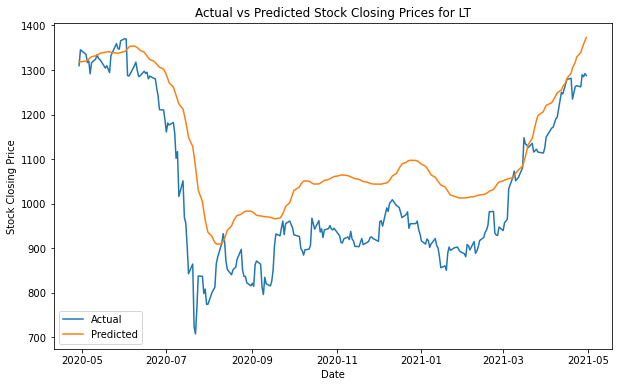

"for symbol, metrics in stock_metrics.items():\n    print(f'Stock: {symbol}, Metrics: {metrics}', sep = '\n')"

In [6]:
# Calculate rolling mean and standard deviation for the 'Close' column
df['50_day_mean'] = df['Close'].rolling(window=50).mean()
df['200_day_mean'] = df['Close'].rolling(window=200).mean()
df['50_day_std'] = df['Close'].rolling(window=50).std()
df['200_day_std'] = df['Close'].rolling(window=200).std()

# Drop rows with NaN values resulting from rolling calculations
df.dropna(inplace=True)

# Define features and target
features = ['Open', 'High', 'Low', 'Close', '50_day_mean', '200_day_mean', '50_day_std', '200_day_std']
target = 'Close'

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Dictionary to store metrics for each stock
stock_metrics = {}

# Process each stock
for symbol in df['Symbol'].unique():
    stock_df = df[df['Symbol'] == symbol].copy()
    
    # Scale features
    scaled_features = scaler.fit_transform(stock_df[features])
    scaled_target = scaler.fit_transform(stock_df[[target]])
    
    X, y = [], []
    dates = []  # List to store the corresponding dates for X and y
    time_steps = 30
    for i in range(time_steps, len(stock_df)):
        X.append(scaled_features[i-time_steps:i])
        y.append(scaled_target[i])
        dates.append(stock_df['Date'].iloc[i])  # Store the corresponding date
        
    X=np.array(X)
    y=np.array(y)
    
    # Convert dates list to a NumPy array for easier indexing
    dates = np.array(dates)
    
    '''# Create sequences
    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X[i:(i + time_steps)])
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)

    time_steps = 30
    X, y = create_dataset(scaled_features, scaled_target, time_steps)'''
    
    # Split into training and testing datasets based on the specified dates
    '''train_mask = stock_df['Date'] < pd.Timestamp('2020-01-01')
    test_mask = (stock_df['Date'] >= pd.Timestamp('2020-01-01')) & (stock_df['Date'] < pd.Timestamp('2021-01-01'))
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]'''
    
    # Now create masks based on the adjusted dates array
    train_mask = dates < pd.Timestamp('2020-01-01')
    test_mask = (dates >= pd.Timestamp('2020-01-01')) & (dates < pd.Timestamp('2021-01-01'))
    
    # Use these masks to split the data
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    
    # Build the LSTM model
    model = Sequential([
        LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Fit the model
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)
    
    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test)
    
    '''# Calculate metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    nrmse = rmse / (np.max(y_test) - np.min(y_test))
    actual_growth = ((y_test[-1][0] - y_test[0][0]) / y_test[0][0]) * 100
    predicted_growth = ((predictions[-1][0] - predictions[0][0]) / predictions[0][0]) * 100'''
    
    mse, rmse, mae, nrmse, actual_growth, predicted_growth = stockMetrics(y_test, predictions)
    
    # Store metrics
    stock_metrics[symbol] = {
        'MSE': mse,
        'RMSE': rmse,
        'NRMSE': nrmse,
        'MAE': mae,
        'Actual Growth %': actual_growth,
        'Predicted Growth %': predicted_growth
    }
    
    print(f'Metrics of {symbol}:')
    print(f'MSE: {mse}, RMSE: {rmse}, NRMSE: {nrmse}, MAE: {mae}, Actual Growth: {actual_growth}, Predicted Growth: {predicted_growth}')
    
    stockActVsPred(stock_df, y_test, predictions)

    '''# Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(stock_df['Date'][len(stock_df)-len(predictions):], y_test, label='Actual')
    plt.plot(stock_df['Date'][len(stock_df)-len(predictions):], predictions, label='Predicted')
    plt.title(f'Actual vs Predicted Stock Closing Prices for {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Stock Closing Price')
    plt.legend()
    plt.show()'''

# Output metrics for each stock
'''for symbol, metrics in stock_metrics.items():
    print(f'Stock: {symbol}, Metrics: {metrics}', sep = '\n')'''
